## Predictive modelling

Pada dasarnya, survival rate maupun average body weight ditentukan oleh kualitas air, pakan, daya tahan benur, cuaca, dan kepadatan tiap kolam. Dengan dataset yang dimiliki, maka pembuatan predictive model bisa dilakukan dengan kombinasi parameter :

    1. Kualitas Air (measurements.csv)
    2. Pakan (feeds.csv)
    3. Kepadatan (cycles.csv)


Target label menggunakan hasil pengolahan data survival rate dari hasil pengolahan data sebelumnya yang telah disimpan pada file result_sr_1.csv

### Survival Rate


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Membaca data
measurements_df = pd.read_csv('Data/measurements.csv')
feeds_df = pd.read_csv('Data/feeds.csv')
cycles_df = pd.read_csv('Data/cycles.csv')
survival_rate_df = pd.read_csv('result_sr_1.csv')

# Daftar semua kolom numerik untuk diagregasi
numeric_columns = [
    'morning_temperature', 'evening_temperature', 'morning_do', 'evening_do',
    'morning_salinity', 'evening_salinity', 'morning_pH', 'evening_pH',
    'transparency', 'turbidity', 'ammonia', 'nitrate', 'nitrite',
    'alkalinity', 'hardness', 'calcium', 'magnesium', 'carbonate',
    'bicarbonate', 'tom', 'total_plankton_'
]

# Pra-pemrosesan data kualitas air
agg_dict = {col: ['mean', 'min', 'max'] for col in numeric_columns}
measurements_agg = measurements_df.groupby('cycle_id').agg(agg_dict)

# Memperbaiki penamaan kolom
measurements_agg.columns = ['_'.join(col).strip() for col in measurements_agg.columns.values]
measurements_agg = measurements_agg.reset_index()

# Pra-pemrosesan data pakan
feeds_agg = feeds_df.groupby('cycle_id')['quantity'].sum().reset_index()
feeds_agg.columns = ['cycle_id', 'total_feed']

# Menggabungkan semua data
combined_data = pd.merge(measurements_agg, feeds_agg, on='cycle_id', how='inner')
combined_data = pd.merge(combined_data, cycles_df[['id', 'area']], left_on='cycle_id', right_on='id', how='inner')
combined_data = pd.merge(combined_data, survival_rate_df[['id', 'survival_rate']], on='id', how='inner')

In [10]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2901 entries, 0 to 2900
Data columns (total 68 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cycle_id                  2901 non-null   int64  
 1   morning_temperature_mean  2213 non-null   float64
 2   morning_temperature_min   2213 non-null   float64
 3   morning_temperature_max   2213 non-null   float64
 4   evening_temperature_mean  2174 non-null   float64
 5   evening_temperature_min   2174 non-null   float64
 6   evening_temperature_max   2174 non-null   float64
 7   morning_do_mean           1895 non-null   float64
 8   morning_do_min            1895 non-null   float64
 9   morning_do_max            1895 non-null   float64
 10  evening_do_mean           1974 non-null   float64
 11  evening_do_min            1974 non-null   float64
 12  evening_do_max            1974 non-null   float64
 13  morning_salinity_mean     2345 non-null   float64
 14  morning_

#### Ujicoba training dengan semua parameter yang ada untuk melihat feature mana yang tidak terlalu berpengaruh

In [11]:
# Mempersiapkan fitur dan target
X = combined_data.drop(['id', 'cycle_id', 'survival_rate'], axis=1)
y = combined_data['survival_rate']

# Menangani nilai yang hilang
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Membuat dan melatih model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Membuat prediksi
y_pred = model.predict(X_test)

# Mengevaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Menampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Mencetak semua fitur penting
print("\nSemua Fitur Penting:")
print(feature_importance)

# Menyimpan hasil ke dalam file CSV
csv_filename = 'feature_importance_SR.csv'
feature_importance.to_csv(csv_filename, index=False)
print(f"\nHasil telah disimpan dalam file: {csv_filename}")

Mean Squared Error: 434.25
R-squared Score: 0.50

Semua Fitur Penting:
                  feature  importance
63             total_feed    0.192923
64                   area    0.174813
18        morning_pH_mean    0.067325
12  morning_salinity_mean    0.037775
20         morning_pH_max    0.025383
..                    ...         ...
34            nitrate_min    0.000771
35            nitrate_max    0.000726
27         turbidity_mean    0.000243
28          turbidity_min    0.000231
29          turbidity_max    0.000039

[65 rows x 2 columns]

Hasil telah disimpan dalam file: feature_importance_SR.csv


### Training dengan Feature yang telah disesuaikan

In [12]:
# Buang feature dengan importance < 0.01

# Memfilter fitur-fitur dengan nilai importance >= 0.01
important_features = feature_importance[feature_importance['importance'] >= 0.01]

# Mendapatkan nama-nama fitur penting
important_feature_names = important_features['feature'].tolist()

# Menambahkan kolom 'id', 'cycle_id', dan 'survival_rate' ke daftar fitur penting
columns_to_keep = ['id', 'cycle_id', 'survival_rate'] + important_feature_names

# Memfilter combined_data untuk hanya menyimpan kolom-kolom penting
filtered_merged_data = combined_data[columns_to_keep]

# Menampilkan hasil
print("Kolom-kolom yang dipertahankan:")
print(filtered_merged_data.columns.tolist())

# Menampilkan jumlah fitur yang dipertahankan dan dibuang
print(f"\nJumlah fitur yang digunakan: {len(filtered_merged_data.columns)}")
print(f"Jumlah fitur yang dibuang: {len(combined_data.columns) - len(filtered_merged_data.columns)}")

Kolom-kolom yang dipertahankan:
['id', 'cycle_id', 'survival_rate', 'total_feed', 'area', 'morning_pH_mean', 'morning_salinity_mean', 'morning_pH_max', 'morning_do_min', 'evening_temperature_max', 'evening_do_mean', 'evening_pH_mean', 'evening_temperature_mean', 'evening_do_max', 'alkalinity_max', 'evening_do_min', 'morning_temperature_max', 'morning_pH_min', 'morning_temperature_mean', 'evening_temperature_min', 'tom_mean', 'morning_temperature_min', 'morning_do_max', 'morning_salinity_min', 'morning_do_mean', 'morning_salinity_max', 'tom_max', 'evening_pH_max', 'transparency_mean', 'evening_salinity_min', 'evening_salinity_max', 'evening_pH_min']

Jumlah fitur yang digunakan: 32
Jumlah fitur yang dibuang: 36


In [13]:
# Menampilkan jumlah baris sebelum pembuangan
print(f"Jumlah baris sebelum pembuangan: {len(filtered_merged_data)}")

# Membuang baris yang memiliki setidaknya satu nilai NaN
filtered_merged_data_clean = filtered_merged_data.dropna()

# Menampilkan jumlah baris setelah pembuangan
print(f"Jumlah baris setelah pembuangan: {len(filtered_merged_data_clean)}")

# Menampilkan beberapa baris pertama dari data yang telah dibersihkan
print("\nBeberapa baris pertama dari data yang telah dibersihkan:")
print(filtered_merged_data_clean.head())

# Menampilkan informasi tentang kolom-kolom yang tersisa
print("\nInformasi kolom:")
print(filtered_merged_data_clean.info())

Jumlah baris sebelum pembuangan: 2901
Jumlah baris setelah pembuangan: 609

Beberapa baris pertama dari data yang telah dibersihkan:
        id  cycle_id  survival_rate  total_feed    area  morning_pH_mean  \
267  11042     11042      25.340680       325.0  1100.0         7.557072   
270  11081     11081      13.951557       626.1  1100.0         8.194130   
430  14094     14094      47.289643      1210.0  1064.0         7.871799   
431  14095     14095     100.000000      1343.0  1082.0         7.863243   
432  14096     14096      92.193398      3677.0  1680.0         7.844374   

     morning_salinity_mean  morning_pH_max  morning_do_min  \
267              34.046449           8.565           1.452   
270              11.175826           8.812           1.260   
430              18.030825           8.510           2.589   
431              19.357537           8.391           2.731   
432              17.868874           8.556           2.600   

     evening_temperature_max  ...  mo

In [14]:
# Menampilkan jumlah baris sebelum pengisian
print(f"Jumlah baris sebelum pengisian: {len(filtered_merged_data)}")

# Mengisi nilai yang hilang dengan rata-rata dari kolom yang sama
filtered_merged_data_filled = filtered_merged_data.fillna(filtered_merged_data.mean())

# Menampilkan jumlah baris setelah pengisian
print(f"Jumlah baris setelah pengisian: {len(filtered_merged_data_filled)}")

# Menampilkan beberapa baris pertama dari data yang telah diisi
print("\nBeberapa baris pertama dari data yang telah diisi:")
print(filtered_merged_data_filled.head())

# Menampilkan informasi tentang kolom-kolom
print("\nInformasi kolom:")
print(filtered_merged_data_filled.info())

# Memeriksa apakah masih ada nilai NaN yang tersisa
print("\nJumlah nilai NaN yang tersisa:")
print(filtered_merged_data_filled.isnull().sum())

Jumlah baris sebelum pengisian: 2901
Jumlah baris setelah pengisian: 2901

Beberapa baris pertama dari data yang telah diisi:
     id  cycle_id  survival_rate  total_feed    area  morning_pH_mean  \
0  3458      3458      78.449328      9987.0  4968.0          8.19122   
1  3459      3459      77.715188     10913.0  4968.0          8.19122   
2  4036      4036      89.608128       480.1   800.0          8.19122   
3  4038      4038     100.000000      7790.6  2700.0          8.19122   
4  4039      4039     100.000000      3770.5  1030.0          8.19122   

   morning_salinity_mean  morning_pH_max  morning_do_min  \
0              23.835304       14.053916        3.540382   
1              23.835304       14.053916        3.540382   
2              23.835304       14.053916        3.540382   
3              23.835304       14.053916        3.540382   
4              23.835304       14.053916        3.540382   

   evening_temperature_max  ...  morning_do_max  morning_salinity_min  \
0

In [15]:
# Mempersiapkan fitur dan target
X = filtered_merged_data_clean.drop(['id', 'cycle_id', 'survival_rate'], axis=1)
y = filtered_merged_data_clean['survival_rate']

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Membuat dan melatih model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Membuat prediksi
y_pred = model.predict(X_test)

# Mengevaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Menampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFitur Terpenting:")
print(feature_importance.head(32))

Mean Squared Error: 220.60
R-squared Score: 0.74

Fitur Terpenting:
                     feature  importance
9   evening_temperature_mean    0.136585
0                 total_feed    0.101623
15  morning_temperature_mean    0.101197
5             morning_do_min    0.095620
2            morning_pH_mean    0.086978
1                       area    0.048786
20      morning_salinity_min    0.038069
8            evening_pH_mean    0.030329
17                  tom_mean    0.026660
10            evening_do_max    0.025896
11            alkalinity_max    0.025381
14            morning_pH_min    0.023639
27      evening_salinity_max    0.022921
23                   tom_max    0.022537
25         transparency_mean    0.022225
3      morning_salinity_mean    0.022005
21           morning_do_mean    0.021448
22      morning_salinity_max    0.019706
19            morning_do_max    0.018452
6    evening_temperature_max    0.015731
13   morning_temperature_max    0.012572
24            evening_pH_max  

In [35]:
# Mempersiapkan fitur dan target
X = filtered_merged_data_clean.drop(['id', 'cycle_id', 'survival_rate'], axis=1)
y = filtered_merged_data_clean['survival_rate']

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Daftar model yang akan digunakan
models = [
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=1.0)),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=5)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
]

# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Melatih dan mengevaluasi semua model
results = []
for name, model in models:
    mse, r2 = train_and_evaluate(model, X_train, X_test, y_train, y_test)
    results.append((name, mse, r2))
    print(f"\n{name}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")

# Menampilkan hasil perbandingan
print("\nPerbandingan Model:")
for name, mse, r2 in results:
    print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")

# Memilih model terbaik berdasarkan R-squared Score
best_model = max(results, key=lambda x: x[2])
print(f"\nModel terbaik: {best_model[0]} dengan R-squared Score: {best_model[2]:.2f}")

# Menampilkan kepentingan fitur untuk Random Forest (sebagai contoh)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFitur Terpenting (Random Forest):")
print(feature_importance.head(32))


Random Forest:
Mean Squared Error: 220.60
R-squared Score: 0.74

XGBoost:
Mean Squared Error: 207.94
R-squared Score: 0.76

Linear Regression:
Mean Squared Error: 527.74
R-squared Score: 0.39

Ridge Regression:
Mean Squared Error: 557.99
R-squared Score: 0.35

Lasso Regression:
Mean Squared Error: 540.71
R-squared Score: 0.37

K-Nearest Neighbors:
Mean Squared Error: 304.88
R-squared Score: 0.65

Gradient Boosting:
Mean Squared Error: 182.77
R-squared Score: 0.79

Perbandingan Model:
Random Forest: MSE = 220.60, R2 = 0.74
XGBoost: MSE = 207.94, R2 = 0.76
Linear Regression: MSE = 527.74, R2 = 0.39
Ridge Regression: MSE = 557.99, R2 = 0.35
Lasso Regression: MSE = 540.71, R2 = 0.37
K-Nearest Neighbors: MSE = 304.88, R2 = 0.65
Gradient Boosting: MSE = 182.77, R2 = 0.79

Model terbaik: Gradient Boosting dengan R-squared Score: 0.79

Fitur Terpenting (Random Forest):
                     feature  importance
9   evening_temperature_mean    0.136585
0                 total_feed    0.101623
15


Fitur Terpenting:
                     feature  importance
0                 total_feed    0.142533
9   evening_temperature_mean    0.140873
2            morning_pH_mean    0.112801
1                       area    0.109055
5             morning_do_min    0.106340
15  morning_temperature_mean    0.066058
20      morning_salinity_min    0.057788
23                   tom_max    0.029956
11            alkalinity_max    0.027157
8            evening_pH_mean    0.021613
13   morning_temperature_max    0.020373
28            evening_pH_min    0.019075
25         transparency_mean    0.018313
10            evening_do_max    0.017883
7            evening_do_mean    0.013888
17                  tom_mean    0.013711
26      evening_salinity_min    0.012121
3      morning_salinity_mean    0.011945
19            morning_do_max    0.011740
12            evening_do_min    0.010070
18   morning_temperature_min    0.007617
27      evening_salinity_max    0.006829
24            evening_pH_max    0.0044

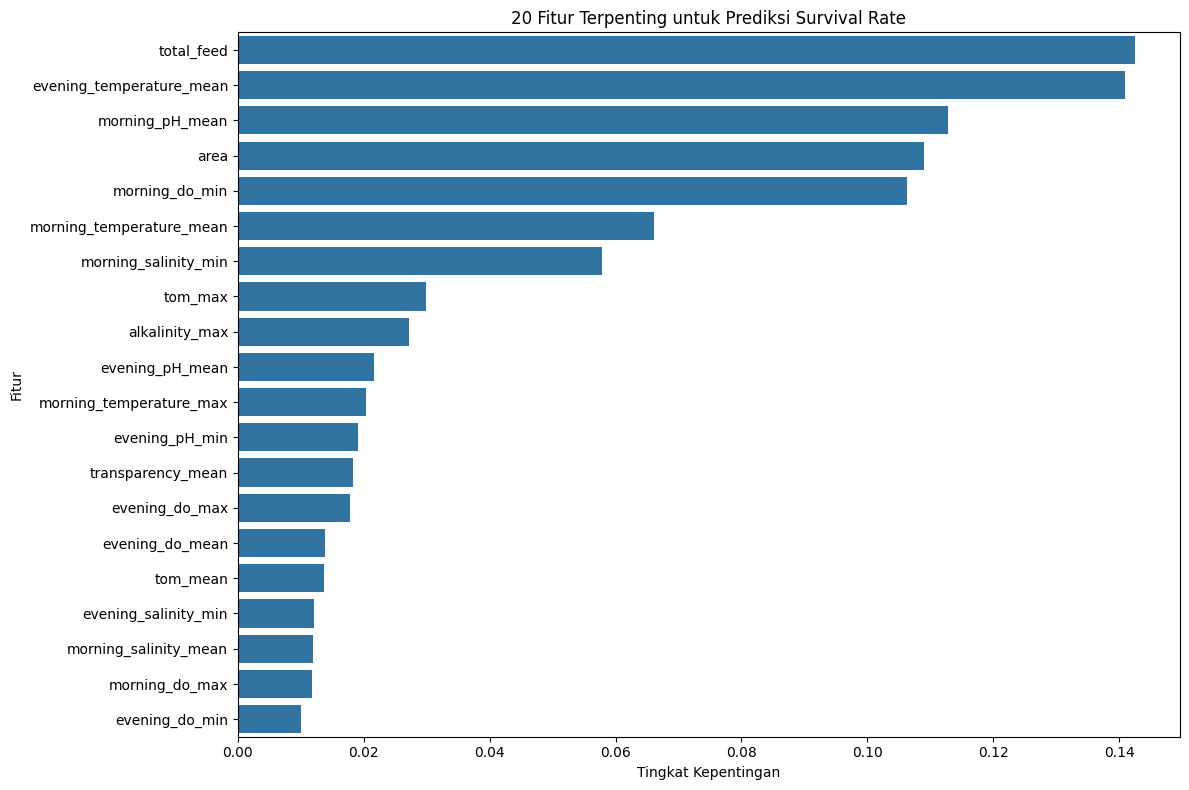

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFitur Terpenting:")
print(feature_importance.head(32))

# Membuat grafik kepentingan fitur
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('20 Fitur Terpenting untuk Prediksi Survival Rate')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()


Fitur Terpenting:
                     feature  importance
0                 total_feed    0.192922
9   evening_temperature_mean    0.179498
25         transparency_mean    0.114731
20      morning_salinity_min    0.111771
16   evening_temperature_min    0.093471
26      evening_salinity_min    0.087694
12            evening_do_min    0.087101
1                       area    0.077766
14            morning_pH_min    0.067732
28            evening_pH_min    0.044292
6    evening_temperature_max    0.036767
8            evening_pH_mean    0.017124
3      morning_salinity_mean    0.013165
24            evening_pH_max    0.007955
18   morning_temperature_min    0.006292
5             morning_do_min    0.006190
13   morning_temperature_max    0.001429
4             morning_pH_max    0.000000
22      morning_salinity_max    0.000000
27      evening_salinity_max    0.000000
23                   tom_max    0.000000
19            morning_do_max    0.000000
21           morning_do_mean    0.0000

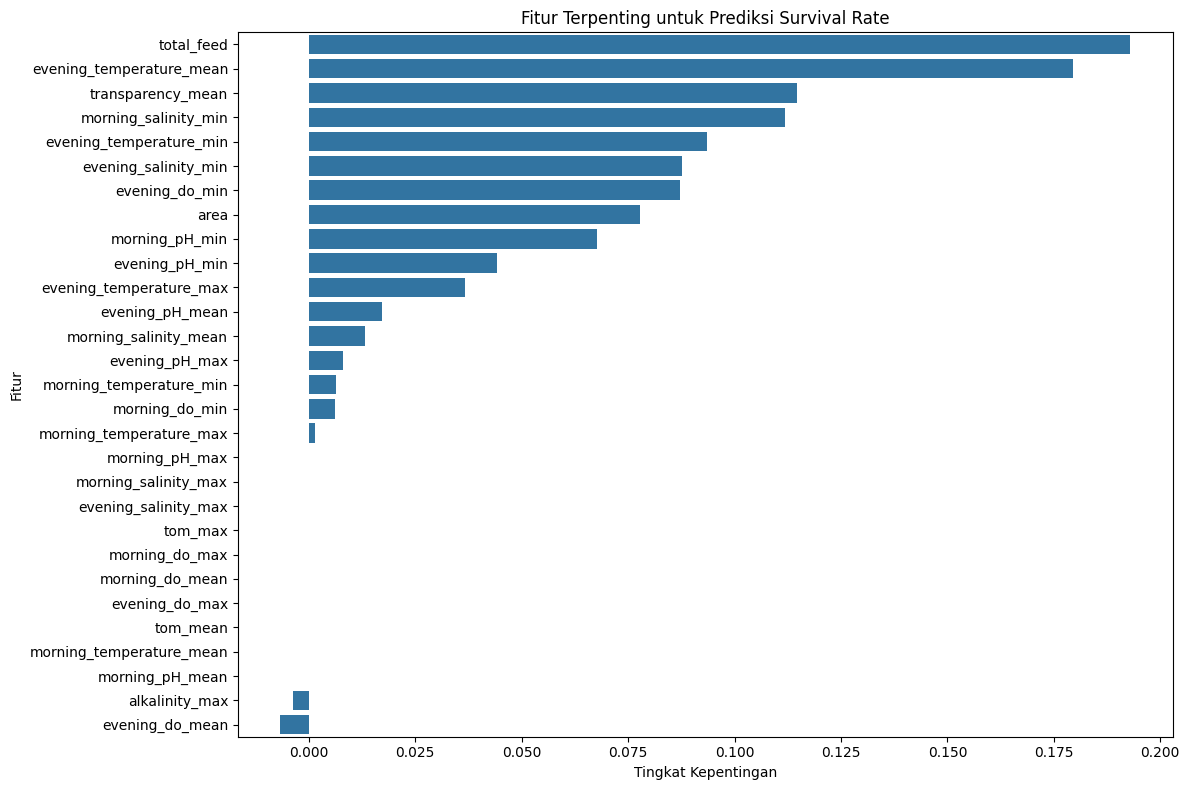

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Jika metodenya clustering (KNN)
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Membuat DataFrame untuk kepentingan fitur
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFitur Terpenting:")
print(feature_importance)

# Membuat grafik kepentingan fitur
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Fitur Terpenting untuk Prediksi Survival Rate')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

In [37]:
from joblib import dump, load

# Menyimpan model dan scaler menggunakan joblib
dump(model, 'survival_rate_prediction_model.joblib')
dump(scaler, 'survival_rate_prediction_scaler.joblib')

print("\nModel dan scaler telah disimpan.")


Model dan scaler telah disimpan.


In [38]:
import numpy as np
from joblib import load

# Memuat model dan scaler
loaded_model = load('survival_rate_prediction_model.joblib')
loaded_scaler = load('survival_rate_prediction_scaler.joblib')

# Daftar semua fitur yang digunakan saat melatih model (29 fitur)
all_features = [
    'evening_temperature_mean', 'total_feed', 'morning_temperature_mean',
    'morning_do_min', 'morning_pH_mean', 'area', 'morning_salinity_min',
    'evening_pH_mean', 'tom_mean', 'evening_do_max', 'alkalinity_max',
    'morning_pH_min', 'evening_salinity_max', 'tom_max', 'transparency_mean',
    'morning_salinity_mean', 'morning_do_mean', 'morning_salinity_max',
    'morning_do_max', 'evening_temperature_max', 'morning_temperature_max',
    'evening_pH_max', 'evening_salinity_min', 'evening_temperature_min',
    'evening_pH_min', 'morning_temperature_min', 'evening_do_mean',
    'morning_pH_max', 'evening_do_min'
]

# Contoh data untuk prediksi (gunakan nilai yang masuk akal untuk semua 29 fitur)
sample_data = np.array([[25, 1000, 26, 5, 7.5, 5000, 15, 7.6, 30, 6, 120, 7.2, 20, 35, 40,
                         18, 5.5, 17, 6.5, 27, 28, 7.8, 14, 24, 7.4, 23, 5.8, 7.7, 4.5]])

# Memastikan jumlah fitur sesuai
if sample_data.shape[1] != len(all_features):
    raise ValueError(f"Sample data harus memiliki {len(all_features)} fitur, tetapi memiliki {sample_data.shape[1]} fitur.")

sample_data_scaled = loaded_scaler.transform(sample_data)
prediction = loaded_model.predict(sample_data_scaled)
print(f"\nPrediksi Survival Rate : {prediction[0]:.2f}")


Prediksi Survival Rate : 34.77


c:\Users\mmasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Average Body Weight

In [22]:
import pandas as pd

# Membaca file-file CSV
samplings_df = pd.read_csv('Data/samplings.csv')
feeds_df = pd.read_csv('Data/feeds.csv')
cycles_df = pd.read_csv('Data/cycles.csv')

# Menghitung ABW per siklus
abw_per_cycle = samplings_df.groupby('cycle_id')['average_weight'].mean().reset_index()
abw_per_cycle.columns = ['cycle_id', 'ABW']

# Menghitung total pakan per siklus
total_feed = feeds_df.groupby('cycle_id')['quantity'].sum().reset_index()
total_feed.columns = ['cycle_id', 'total_feed']

# Menggabungkan data
combined_df = pd.merge(abw_per_cycle, total_feed, on='cycle_id', how='outer')
combined_df = pd.merge(combined_df, cycles_df[['id', 'area']], left_on='cycle_id', right_on='id', how='outer')

# Membersihkan dataframe
combined_df = combined_df.drop('id', axis=1)
combined_df = combined_df.rename(columns={'area': 'pond_area'})

# Menghitung kepadatan (jumlah udang per meter persegi)
combined_df['density'] = combined_df['total_feed'] / (combined_df['ABW'] / 1000) / combined_df['pond_area']

# Menampilkan hasil
print("Dataframe gabungan:")
print(combined_df)

# Menyimpan dataframe ke file CSV
combined_df.to_csv('combined_abw_feed_density.csv', index=False)
print(combined_df.info())

Dataframe gabungan:
      cycle_id        ABW  total_feed  pond_area     density
0       3458.0  13.590000     9987.00     4968.0  147.922421
1       3459.0  14.322308    10913.00     4968.0  153.373232
2       4036.0        NaN      480.10      800.0         NaN
3       4038.0  10.585366     7790.60     2700.0  272.584571
4       4039.0  10.881250     3770.50     1030.0  336.420872
...        ...        ...         ...        ...         ...
2612   29619.0   5.635000     1043.40      216.0  857.241447
2613   29659.0   4.000000       15.00     2183.0    1.717820
2614   29679.0  19.534000      488.35       78.5  318.471338
2615   29873.0   7.020000     1798.80      900.0  284.710351
2616   29874.0   7.456667     1110.80      900.0  165.519297

[2617 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cycle_id    2617 non-null   fl

In [23]:
# Menghapus semua baris yang mengandung nilai NaN
combined_df_clean = combined_df.dropna()

# Menampilkan hasil
print("Dataframe gabungan setelah menghapus NaN:")
print(combined_df_clean)

# Menampilkan informasi tentang dataframe yang telah dibersihkan
print("\nInformasi dataframe setelah pembersihan:")
print(combined_df_clean.info())

# Menampilkan jumlah baris yang dihapus
print(f"\nJumlah baris yang dihapus: {len(combined_df) - len(combined_df_clean)}")

Dataframe gabungan setelah menghapus NaN:
      cycle_id        ABW  total_feed  pond_area     density
0       3458.0  13.590000     9987.00     4968.0  147.922421
1       3459.0  14.322308    10913.00     4968.0  153.373232
3       4038.0  10.585366     7790.60     2700.0  272.584571
4       4039.0  10.881250     3770.50     1030.0  336.420872
5       4044.0  12.280714     7182.50     1250.0  467.888094
...        ...        ...         ...        ...         ...
2612   29619.0   5.635000     1043.40      216.0  857.241447
2613   29659.0   4.000000       15.00     2183.0    1.717820
2614   29679.0  19.534000      488.35       78.5  318.471338
2615   29873.0   7.020000     1798.80      900.0  284.710351
2616   29874.0   7.456667     1110.80      900.0  165.519297

[2418 rows x 5 columns]

Informasi dataframe setelah pembersihan:
<class 'pandas.core.frame.DataFrame'>
Index: 2418 entries, 0 to 2616
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


# Memisahkan fitur dan target
X = combined_df_clean[['total_feed', 'pond_area', 'density']]
y = combined_df_clean['ABW']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Membuat dan melatih model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Membuat prediksi
y_pred = model.predict(X_test_scaled)

# Mengevaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Menampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nKepentingan Fitur:")
print(feature_importance)

# Menyimpan model dan scaler menggunakan joblib
dump(model, 'abw_prediction_model.joblib')
dump(scaler, 'abw_prediction_scaler.joblib')

print("\nModel dan scaler telah disimpan.")

Mean Squared Error: 2.28
R-squared Score: 0.87

Kepentingan Fitur:
      feature  importance
0  total_feed    0.470635
2     density    0.317544
1   pond_area    0.211821

Model dan scaler telah disimpan.


In [39]:
# Menggunakan model yang dimuat untuk prediksi
loaded_model = load('abw_prediction_model.joblib')
loaded_scaler = load('abw_prediction_scaler.joblib')

sample_data = np.array([[1000, 500, 20]])  # total_feed, pond_area, density
sample_data_scaled = loaded_scaler.transform(sample_data)
prediction = loaded_model.predict(sample_data_scaled)
print(f"\nPrediksi ABW menggunakan model yang ditraining : {prediction[0]:.2f}")


Prediksi ABW menggunakan model yang ditraining : 17.62


c:\Users\mmasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Biomass

#### What is biomass?
Biomassa sendiri merupakan jumlah berat total dari populasi udang yang ada pada periode waktu tertentu dan biasanya dinyatakan dalam satuan berat (kilogram atau ton). Biomassa udang dapat diestimasikan melalui perkalian antara survival rate (SR) dengan rata-rata berat udang (ABW) udang pada saat tertentu.



source : https://jala.tech/id/blog/tips-budidaya/10-istilah-yang-ada-di-dashboard-jala-app-dan-artinya

In [26]:
import pandas as pd

# Baca file CSV
sr_df = pd.read_csv('result_sr_1.csv', names=['cycle_id', 'total_seed', 'total_harvested', 'survival_rate'], skiprows=1)
abw_df = pd.read_csv('combined_abw_feed_density.csv')

# Ubah tipe data 'cycle_id' menjadi string di kedua dataframe
sr_df['cycle_id'] = sr_df['cycle_id'].astype(str)
abw_df['cycle_id'] = abw_df['cycle_id'].astype(str).str.split('.').str[0]

# Gabungkan dataframe berdasarkan cycle_id
merged_df = pd.merge(sr_df, abw_df, on='cycle_id', how='inner')

# Hapus baris yang memiliki nilai NaN
merged_df_clean = merged_df.dropna()

# Hitung biomassa (dalam gram)
merged_df_clean['biomass_g'] = merged_df_clean['survival_rate'].astype(float) * merged_df_clean['ABW'] * merged_df_clean['total_seed'].astype(float)
merged_df_clean['biomass_kg'] = merged_df_clean['biomass_g'] / 1000

# Tampilkan hasil
print("\nHasil penggabungan dan pembersihan:")
print(merged_df_clean[['cycle_id', 'survival_rate', 'ABW', 'total_seed', 'biomass_kg']])

# Simpan hasil ke file CSV baru
merged_df_clean.to_csv('biomass_result_clean.csv', index=False)

print(f"\nJumlah baris setelah penggabungan dan pembersihan: {len(merged_df_clean)}")
print("\nInformasi tentang DataFrame hasil:")
print(merged_df_clean.info())


Hasil penggabungan dan pembersihan:
     cycle_id  survival_rate        ABW  total_seed     biomass_kg
0        3458      78.449328  13.590000      566669  604140.759180
1        3459      77.715188  14.322308      566669  630737.072132
3        4038     100.000000  10.585366      350000  370487.804878
4        4039     100.000000  10.881250      210000  228506.250000
5        4044      86.859556  12.280714      215858  230255.164779
...       ...            ...        ...         ...            ...
2896    29619     100.000000   5.635000       70000   39445.000000
2897    29659      16.000000   4.000000       75000    4800.000000
2898    29679     100.000000  19.534000       26671   52099.131400
2899    29873      70.584000   7.020000      125000   61937.460000
2900    29874      37.044000   7.456667      125000   34528.095000

[2700 rows x 5 columns]

Jumlah baris setelah penggabungan dan pembersihan: 2700

Informasi tentang DataFrame hasil:
<class 'pandas.core.frame.DataFrame'>
Ind

C:\Users\mmasa\AppData\Local\Temp\ipykernel_17616\2792705144.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['biomass_g'] = merged_df_clean['survival_rate'].astype(float) * merged_df_clean['ABW'] * merged_df_clean['total_seed'].astype(float)
C:\Users\mmasa\AppData\Local\Temp\ipykernel_17616\2792705144.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['biomass_kg'] = merged_df_clean['biomass_g'] / 1000


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# Baca data yang telah diolah
df = pd.read_csv('biomass_result_clean.csv')

# Pilih fitur dan target
features = ['survival_rate', 'ABW', 'total_seed', 'total_feed', 'pond_area', 'density']
target = 'biomass_kg'

# Pisahkan fitur dan target
X = df[features]
y = df[target]

# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buat dan latih model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Buat prediksi
y_pred = model.predict(X_test_scaled)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Tampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nKepentingan Fitur:")
print(feature_importance)

# Simpan model dan scaler
dump(model, 'biomass_prediction_model.joblib')
dump(scaler, 'biomass_prediction_scaler.joblib')

print("\nModel dan scaler telah disimpan.")

Mean Squared Error: 3089635331.58
R-squared Score: 0.88

Kepentingan Fitur:
         feature  importance
3     total_feed    0.670226
0  survival_rate    0.112368
2     total_seed    0.104171
1            ABW    0.080262
5        density    0.018617
4      pond_area    0.014357

Model dan scaler telah disimpan.


In [28]:
# Contoh penggunaan model untuk prediksi
loaded_model = load('biomass_prediction_model.joblib')
loaded_scaler = load('biomass_prediction_scaler.joblib')

# survival_rate, ABW, total_seed, total_feed, pond_area, density
sample_data = np.array([[80, 15, 100000, 5000, 1000, 100]])  
sample_data_scaled = loaded_scaler.transform(sample_data)
prediction = loaded_model.predict(sample_data_scaled)
print(f"\nPrediksi Biomass: {prediction[0]:.2f} kg")


Prediksi Biomass: 198433.34 kg


c:\Users\mmasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Revenue Forecast

Penentuan revenue dilakukan dengan meninjau Size dan Weight. Selain itu, faktor geografis juga berpengaruh. Sehingga dimasukkan juga faktor geografis berupa Provinsi/Kota

In [29]:
import pandas as pd

# Baca file harvests.csv
harvests_df = pd.read_csv('Data/harvests.csv')

# Baca file farms.csv
farms_df = pd.read_csv('Data/farms.csv')

# Pilih kolom yang diinginkan dari harvests_df
harvests_selected = harvests_df[['cycle_id', 'size', 'weight', 'selling_price']]

# Gabungkan dataframe
gabungan_df = pd.merge(harvests_selected, farms_df[['id', 'province', 'regency']], left_on='cycle_id', right_on='id', how='left')

# Hapus kolom id yang duplikat
gabungan_df = gabungan_df.drop('id', axis=1)
print(gabungan_df[['size', 'weight']].head(100))

# Hitung jumlah nilai null dalam kolom 'size' dan 'weight'
print("\nJumlah nilai null dalam kolom 'size' dan 'weight':")
print(gabungan_df[['size', 'weight']].isnull().sum())

# Tampilkan nilai unik dan jumlahnya untuk kolom 'size'
print("\nNilai unik dan jumlahnya untuk kolom 'size':")
print(gabungan_df['size'].value_counts().head(10))  # Menampilkan 10 nilai teratas

      size   weight
0   399.86     0.01
1   300.00    46.00
2   300.00    10.00
3   110.00   270.50
4   190.00   270.50
..     ...      ...
95   94.00   304.23
96   94.00     8.44
97   39.00  3797.59
98   39.00    10.00
99   39.00     3.00

[100 rows x 2 columns]

Jumlah nilai null dalam kolom 'size' dan 'weight':
size      0
weight    0
dtype: int64

Nilai unik dan jumlahnya untuk kolom 'size':
size
100.0    188
120.0    148
150.0    133
200.0    123
130.0    103
70.0     102
180.0    101
80.0     101
110.0     91
60.0      83
Name: count, dtype: int64


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Bersihkan data dari nilai null dan infinity
gabungan_df_clean = gabungan_df.dropna(subset=['size', 'weight', 'selling_price'])
gabungan_df_clean = gabungan_df_clean[~gabungan_df_clean.isin([np.inf, -np.inf]).any(axis=1)]

# Pilih fitur dan target
X = gabungan_df_clean[['size', 'weight']]
y = gabungan_df_clean['selling_price']

# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fungsi untuk melatih model dan menampilkan hasil
def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    return model, r2

# Daftar model yang akan digunakan
models = [
    (Ridge(), "Ridge Regression"),
    (Lasso(), "Lasso Regression"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest"),
    (GradientBoostingRegressor(n_estimators=100, random_state=42), "Gradient Boosting"),
    (KNeighborsRegressor(), "K-Nearest Neighbors"),
    (XGBRegressor(random_state=42), "XGBoost"),
]

# Melatih dan mengevaluasi semua model
results = []
for model, name in models:
    trained_model, r2 = train_and_evaluate(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append((name, trained_model, r2))

# Memilih model terbaik berdasarkan R-squared Score
best_model_name, best_model, best_r2 = max(results, key=lambda x: x[2])
print(f"\nModel terbaik: {best_model_name} dengan R-squared Score: {best_r2:.2f}")

# Contoh prediksi menggunakan model terbaik
sample_data = np.array([[100, 500]])  # Contoh data: size=100, weight=500
sample_data_scaled = scaler.transform(sample_data)
prediction = best_model.predict(sample_data_scaled)
print(f"\nPrediksi harga jual untuk size=100 dan weight=500: {prediction[0]:.2f}")


Ridge Regression:
Mean Squared Error: 3149341654670425.00
R-squared Score: 0.43

Lasso Regression:
Mean Squared Error: 3149023474356886.50
R-squared Score: 0.43

Random Forest:
Mean Squared Error: 2041782547250495.75
R-squared Score: 0.63

Gradient Boosting:
Mean Squared Error: 1735922799672199.25
R-squared Score: 0.69

K-Nearest Neighbors:
Mean Squared Error: 2482371330066496.50
R-squared Score: 0.55

XGBoost:
Mean Squared Error: 2979375034994621.50
R-squared Score: 0.46

Model terbaik: Gradient Boosting dengan R-squared Score: 0.69

Prediksi harga jual untuk size=100 dan weight=500: 19991252.31


c:\Users\mmasa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Fitur Terpenting:
  feature  importance
1  weight    0.960385
0    size    0.039615


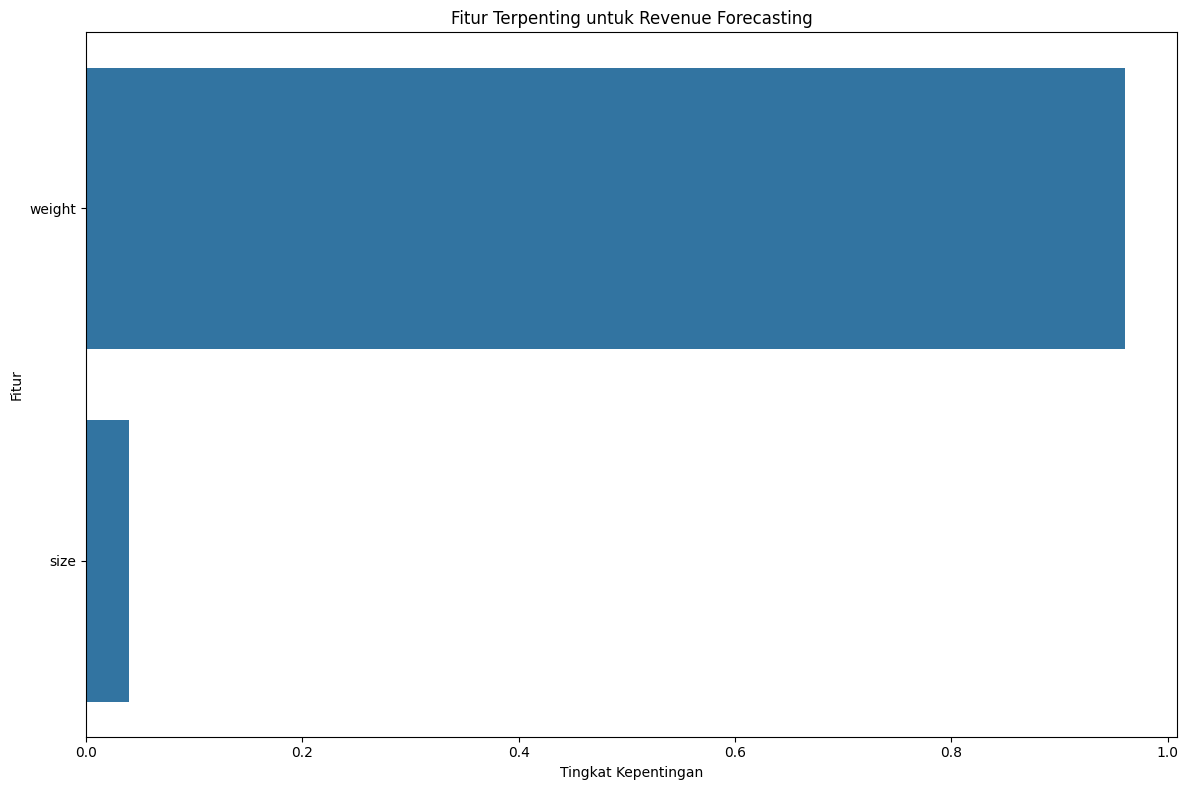

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan kepentingan fitur
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFitur Terpenting:")
print(feature_importance.head(32))

# Membuat grafik kepentingan fitur
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Fitur Terpenting untuk Revenue Forecasting')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

### FCR

In [31]:
import pandas as pd

# Membaca file CSV
feeds_df = pd.read_csv('Data/feeds.csv')
harvests_df = pd.read_csv('Data/harvests.csv')

# Menghitung total pakan per siklus
total_feed = feeds_df.groupby('cycle_id')['quantity'].sum().reset_index()

# Menghitung total berat panen per siklus
total_harvest = harvests_df.groupby('cycle_id')['weight'].sum().reset_index()

# Menggabungkan data pakan dan panen
fcr_df = pd.merge(total_feed, total_harvest, on='cycle_id', how='inner')

# Menghitung FCR
fcr_df['FCR'] = fcr_df['quantity'] / fcr_df['weight']

# Menampilkan hasil
print(fcr_df)

# Menghitung rata-rata FCR
average_fcr = fcr_df['FCR'].mean()
print(f"Rata-rata FCR: {average_fcr:.2f}")

      cycle_id  quantity   weight       FCR
0         3458   9987.00  7382.93  1.352715
1         3459  10913.00  7454.04  1.464038
2         4036    480.10   441.00  1.088662
3         4038   7790.60  6521.86  1.194537
4         4039   3770.50  2952.54  1.277036
...        ...       ...      ...       ...
2485     29619   1043.40   850.00  1.227529
2486     29659     15.00    60.00  0.250000
2487     29679    488.35   609.00  0.801888
2488     29873   1798.80  1038.00  1.732948
2489     29874   1110.80   661.50  1.679214

[2490 rows x 4 columns]
Rata-rata FCR: inf
